# Skip-gram

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
import re
import time


In [2]:
class SkipGram:
    def __init__(self, text=None, embedding_dim=100, window_size=2, negative_samples=5,
                 min_count=5, subsample_threshold=1e-5, learning_rate=0.025):
        """
        Initialize the Skip-Gram model

        Args:
            text (str): Text corpus to train on
            embedding_dim (int): Dimension of word embeddings
            window_size (int): Context window size (on each side)
            negative_samples (int): Number of negative samples per positive sample
            min_count (int): Minimum word frequency to be included in vocabulary
            subsample_threshold (float): Threshold for subsampling frequent words
            learning_rate (float): Initial learning rate
        """
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.negative_samples = negative_samples
        self.min_count = min_count
        self.subsample_threshold = subsample_threshold
        self.learning_rate = learning_rate
        self.initial_lr = learning_rate

        # Initialize vocabulary and embeddings if text is provided
        if text:
            self.build_vocab(text)
            self.initialize_embeddings()

    def tokenize(self, text):
        """Convert text to lowercase and split into tokens"""
        return re.findall(r'\w+', text.lower())

    def build_vocab(self, text):
        """
        Build vocabulary from text corpus

        Args:
            text (str): Text corpus
        """
        tokens = self.tokenize(text)

        # Count word frequencies
        word_counts = Counter(tokens)
        total_words = sum(word_counts.values())

        # Filter words below min_count
        filtered_words = {word: count for word, count in word_counts.items()
                         if count >= self.min_count}

        # Create word-to-index and index-to-word mappings
        self.word2idx = {}
        self.idx2word = {}
        self.word_counts = {}
        self.discard_probs = {}  # For subsampling

        # Add words to vocabulary
        for idx, (word, count) in enumerate(filtered_words.items()):
            self.word2idx[word] = idx
            self.idx2word[idx] = word
            self.word_counts[word] = count

            # Calculate probability for subsampling frequent words
            # Formula from original word2vec paper
            freq = count / total_words
            self.discard_probs[word] = 1 - np.sqrt(self.subsample_threshold / freq)

        self.vocab_size = len(self.word2idx)
        print(f"Vocabulary size: {self.vocab_size}")

        # Create dataset of word indices
        self.data = [self.word2idx[word] for word in tokens if word in self.word2idx]
        print(f"Total words in dataset after filtering: {len(self.data)}")

    def initialize_embeddings(self):
        """Initialize input and output embeddings"""
        # Initialize weights with small random values
        self.W_input = np.random.uniform(-0.5/self.embedding_dim, 0.5/self.embedding_dim,
                                         (self.vocab_size, self.embedding_dim))
        self.W_output = np.zeros((self.vocab_size, self.embedding_dim))

    def get_target_contexts(self, idx):
        """
        Get context words for a given center word position

        Args:
            idx (int): Index of the center word in the dataset

        Returns:
            list: Indices of context words
        """
        contexts = []
        center_word = self.data[idx]

        # For each position within the window
        for offset in range(-self.window_size, self.window_size + 1):
            if offset == 0:  # Skip the center word itself
                continue

            context_idx = idx + offset
            if 0 <= context_idx < len(self.data):
                context_word = self.data[context_idx]
                contexts.append(context_word)

        return contexts

    def sample_negative(self, positive_samples):
        """
        Sample negative word indices

        Args:
            positive_samples (list): Word indices to exclude from sampling

        Returns:
            list: Negative samples
        """
        # Using unigram distribution raised to 3/4 power as in the paper
        # Here we simplify by sampling based on word frequencies directly
        neg_samples = []
        word_freq = np.array([self.word_counts[self.idx2word[i]] for i in range(self.vocab_size)])
        word_freq = word_freq ** 0.75
        word_prob = word_freq / np.sum(word_freq)

        while len(neg_samples) < self.negative_samples:
            sample = np.random.choice(self.vocab_size, p=word_prob)
            if sample not in positive_samples:
                neg_samples.append(sample)

        return neg_samples

    def sigmoid(self, x):
        """Numerically stable sigmoid function"""
        return np.where(x >= 0,
                       1 / (1 + np.exp(-x)),
                       np.exp(x) / (1 + np.exp(x)))

    def train(self, epochs=5, batch_size=512, print_every=1000):
        """
        Train the Skip-Gram model

        Args:
            epochs (int): Number of epochs to train
            batch_size (int): Mini-batch size
            print_every (int): How often to print progress
        """
        if not hasattr(self, 'data'):
            raise ValueError("No dataset loaded. Call build_vocab() first.")

        print(f"Training Skip-Gram with {self.vocab_size} words, {self.embedding_dim} dimensions")
        print(f"Window size: {self.window_size}, Negative samples: {self.negative_samples}")

        # Total number of word-context pairs
        n_examples = len(self.data)
        steps_per_epoch = n_examples // batch_size
        total_steps = epochs * steps_per_epoch

        # Training loop
        loss_history = []
        step = 0
        start_time = time.time()

        for epoch in range(epochs):
            epoch_loss = 0

            # Create list of word indices to process
            indices = list(range(len(self.data)))
            random.shuffle(indices)

            for batch_start in range(0, len(indices), batch_size):
                batch_indices = indices[batch_start:batch_start + batch_size]
                batch_loss = 0

                # Dynamic learning rate decay
                current_lr = self.initial_lr * (1 - step / total_steps)
                current_lr = max(current_lr, self.initial_lr * 0.0001)  # Minimum learning rate

                # Process each center word in the batch
                for i in batch_indices:
                    center_word_idx = self.data[i]
                    # Apply subsampling - randomly skip frequent words
                    if random.random() < self.discard_probs.get(self.idx2word[center_word_idx], 0):
                        continue

                    context_indices = self.get_target_contexts(i)

                    # For each context word, perform update
                    for context_idx in context_indices:
                        # Positive sample (center word and context word)
                        positive_sample = [center_word_idx, context_idx]

                        # Get negative samples
                        negative_samples = self.sample_negative(positive_sample)

                        # Update for positive sample
                        h = self.W_input[center_word_idx]  # Center word vector
                        u = self.W_output[context_idx]     # Context word vector

                        # Forward pass - positive sample
                        score = np.dot(h, u)
                        sigmoid_score = self.sigmoid(score)
                        pos_loss = -np.log(sigmoid_score + 1e-10)

                        # Gradients for positive sample
                        grad_out = (sigmoid_score - 1) * h
                        grad_in = (sigmoid_score - 1) * u

                        # Update vectors for positive sample
                        self.W_output[context_idx] -= current_lr * grad_out

                        # Negative samples
                        neg_loss = 0
                        for neg_idx in negative_samples:
                            neg_vec = self.W_output[neg_idx]
                            neg_score = np.dot(h, neg_vec)
                            neg_sigmoid = self.sigmoid(neg_score)
                            neg_loss += -np.log(1 - neg_sigmoid + 1e-10)

                            # Gradients for negative sample
                            neg_grad_out = neg_sigmoid * h
                            neg_grad_in = neg_sigmoid * neg_vec

                            # Update vectors for negative sample
                            self.W_output[neg_idx] -= current_lr * neg_grad_out
                            grad_in += neg_grad_in

                        # Update input vector once with accumulated gradients
                        self.W_input[center_word_idx] -= current_lr * grad_in

                        # Add loss
                        batch_loss += (pos_loss + neg_loss)

                # Normalize batch loss
                if len(batch_indices) > 0:
                    batch_loss /= len(batch_indices)
                    epoch_loss += batch_loss

                step += 1

                # Print progress
                if step % print_every == 0:
                    elapsed = time.time() - start_time
                    print(f"Epoch {epoch+1}/{epochs}, Batch {batch_start//batch_size+1}/{steps_per_epoch}, "
                          f"Loss: {batch_loss:.4f}, Time: {elapsed:.2f}s")
                    loss_history.append(batch_loss)

            # Epoch complete
            avg_epoch_loss = epoch_loss / steps_per_epoch
            print(f"Epoch {epoch+1}/{epochs} complete. Average loss: {avg_epoch_loss:.4f}")

        # Normalize embeddings
        self.normalize_embeddings()

        return loss_history

    def normalize_embeddings(self):
        """L2 normalize word vectors"""
        norms = np.sqrt(np.sum(self.W_input ** 2, axis=1, keepdims=True))
        self.W_input = self.W_input / (norms + 1e-10)

    def get_word_vector(self, word):
        """Get embedding vector for a word"""
        if word in self.word2idx:
            return self.W_input[self.word2idx[word]]
        else:
            print(f"Word '{word}' not in vocabulary")
            return None

    def most_similar(self, word, n=10):
        """
        Find n most similar words to a given word

        Args:
            word (str): Query word
            n (int): Number of similar words to return

        Returns:
            list: Tuples of (word, similarity score)
        """
        if word not in self.word2idx:
            print(f"Word '{word}' not in vocabulary")
            return []

        query_vec = self.get_word_vector(word)

        # Compute cosine similarities
        similarities = cosine_similarity([query_vec], self.W_input)[0]

        # Get top n similar words (excluding the query word itself)
        most_similar = []
        sorted_ids = np.argsort(similarities)[::-1]

        for idx in sorted_ids:
            if self.idx2word[idx] != word:
                most_similar.append((self.idx2word[idx], similarities[idx]))
                if len(most_similar) >= n:
                    break

        return most_similar

    def analogy(self, word1, word2, word3, n=5):
        """
        Solve word analogies like "king - man + woman = queen"

        Args:
            word1 (str): First word in analogy (e.g., "king")
            word2 (str): Second word in analogy (e.g., "man")
            word3 (str): Third word in analogy (e.g., "woman")
            n (int): Number of results to return

        Returns:
            list: Tuples of (word, similarity score)
        """
        for word in [word1, word2, word3]:
            if word not in self.word2idx:
                print(f"Word '{word}' not in vocabulary")
                return []

        # Compute target vector: vec(word1) - vec(word2) + vec(word3)
        vec1 = self.get_word_vector(word1)
        vec2 = self.get_word_vector(word2)
        vec3 = self.get_word_vector(word3)

        target_vec = vec1 - vec2 + vec3

        # Normalize target vector
        target_vec = target_vec / np.sqrt(np.sum(target_vec ** 2))

        # Compute cosine similarities
        similarities = cosine_similarity([target_vec], self.W_input)[0]

        # Get top results (excluding the input words)
        results = []
        sorted_ids = np.argsort(similarities)[::-1]

        for idx in sorted_ids:
            word = self.idx2word[idx]
            if word not in [word1, word2, word3]:
                results.append((word, similarities[idx]))
                if len(results) >= n:
                    break

        return results

    def evaluate_similarity(self, similarity_dataset):
        """
        Evaluate the model on a word similarity dataset

        Args:
            similarity_dataset (list): List of (word1, word2, similarity_score) tuples

        Returns:
            float: Spearman correlation between model similarities and human ratings
        """
        model_scores = []
        human_scores = []
        oov_words = set()

        for word1, word2, score in similarity_dataset:
            if word1 not in self.word2idx:
                oov_words.add(word1)
                continue
            if word2 not in self.word2idx:
                oov_words.add(word2)
                continue

            vec1 = self.get_word_vector(word1)
            vec2 = self.get_word_vector(word2)

            sim = cosine_similarity([vec1], [vec2])[0][0]
            model_scores.append(sim)
            human_scores.append(float(score))

        if oov_words:
            print(f"Warning: {len(oov_words)} words not in vocabulary: {', '.join(list(oov_words)[:10])}")
            if len(oov_words) > 10:
                print(f"...and {len(oov_words) - 10} more")

        if len(model_scores) < 2:
            print("Not enough pairs to evaluate")
            return 0.0

        correlation, p_value = spearmanr(human_scores, model_scores)
        print(f"Spearman correlation: {correlation:.4f} (p-value: {p_value:.4f})")
        print(f"Evaluated on {len(model_scores)} word pairs")

        return correlation

    def evaluate_analogies(self, analogy_dataset):
        """
        Evaluate the model on word analogy tasks

        Args:
            analogy_dataset (list): List of (a, b, c, d) tuples representing a:b :: c:d

        Returns:
            float: Accuracy of the model on analogy task
        """
        correct = 0
        total = 0
        oov_analogies = 0

        for a, b, c, d in analogy_dataset:
            if any(word not in self.word2idx for word in [a, b, c, d]):
                oov_analogies += 1
                continue

            # Get top result from analogy task
            results = self.analogy(a, b, c, n=1)
            if not results:
                continue

            predicted_word, _ = results[0]

            if predicted_word == d:
                correct += 1
            total += 1

        if total == 0:
            print("No valid analogies found for evaluation")
            return 0.0

        accuracy = correct / total
        print(f"Analogy accuracy: {accuracy:.4f} ({correct}/{total})")
        print(f"Out-of-vocabulary analogies: {oov_analogies}")

        return accuracy

    def visualize_embeddings(self, words, method='tsne'):
        """
        Visualize word embeddings in 2D space

        Args:
            words (list): List of words to visualize
            method (str): Dimensionality reduction method ('tsne' or 'pca')
        """
        if method == 'tsne':
            from sklearn.manifold import TSNE
            reducer = TSNE(n_components=2, random_state=42)
        elif method == 'pca':
            from sklearn.decomposition import PCA
            reducer = PCA(n_components=2, random_state=42)
        else:
            raise ValueError("Method must be 'tsne' or 'pca'")

        # Filter words that are in vocabulary
        valid_words = [w for w in words if w in self.word2idx]
        if len(valid_words) == 0:
            print("None of the provided words are in vocabulary")
            return

        # Get embeddings for valid words
        word_vectors = np.array([self.get_word_vector(w) for w in valid_words])

        # Reduce dimensions
        embedding_2d = reducer.fit_transform(word_vectors)

        # Plot
        plt.figure(figsize=(12, 10))
        plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.7)

        # Add labels
        for i, word in enumerate(valid_words):
            plt.annotate(word, (embedding_2d[i, 0], embedding_2d[i, 1]),
                         fontsize=11, alpha=0.8)

        plt.title(f"Word Embeddings visualized using {method.upper()}")
        plt.grid(True, alpha=0.4)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def save_embeddings(self, filename):
        """
        Save word embeddings to a text file (word2vec format)

        Args:
            filename (str): Path to save the embeddings
        """
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(f"{self.vocab_size} {self.embedding_dim}\n")
            for word, idx in self.word2idx.items():
                vector_str = ' '.join(str(val) for val in self.W_input[idx])
                f.write(f"{word} {vector_str}\n")

        print(f"Embeddings saved to {filename}")

    def load_embeddings(self, filename):
        """
        Load word embeddings from a text file (word2vec format)

        Args:
            filename (str): Path to the embeddings file
        """
        self.word2idx = {}
        self.idx2word = {}

        with open(filename, 'r', encoding='utf-8') as f:
            header = f.readline().split()
            vocab_size, embedding_dim = int(header[0]), int(header[1])

            self.embedding_dim = embedding_dim
            self.W_input = np.zeros((vocab_size, embedding_dim))

            for i, line in enumerate(f):
                parts = line.rstrip().split(' ')
                word = parts[0]
                vector = np.array([float(val) for val in parts[1:]])

                self.word2idx[word] = i
                self.idx2word[i] = word
                self.W_input[i] = vector

        self.vocab_size = vocab_size
        self.W_output = np.zeros_like(self.W_input)  # Initialize output matrix

        print(f"Loaded embeddings for {self.vocab_size} words with dimension {self.embedding_dim}")



Vocabulary size: 34
Total words in dataset after filtering: 134
Training Skip-Gram with 34 words, 50 dimensions
Window size: 2, Negative samples: 5
Epoch 1/10 complete. Average loss: 0.7798
Epoch 2/10 complete. Average loss: 0.1949
Epoch 3/10 complete. Average loss: 0.1300
Epoch 4/10 complete. Average loss: 0.5199
Epoch 5/10 complete. Average loss: 0.5199
Epoch 6/10, Batch 5/8, Loss: 1.0397, Time: 0.08s
Epoch 6/10 complete. Average loss: 0.3899
Epoch 7/10 complete. Average loss: 0.5199
Epoch 8/10 complete. Average loss: 0.5199
Epoch 9/10 complete. Average loss: 0.3899
Epoch 10/10 complete. Average loss: 0.1300

Most similar words to 'language':
tasks: 0.3094
representation: 0.2761
understanding: 0.2712
is: 0.2659
the: 0.1735

Word analogy: language - natural + artificial = ?
Word 'artificial' not in vocabulary


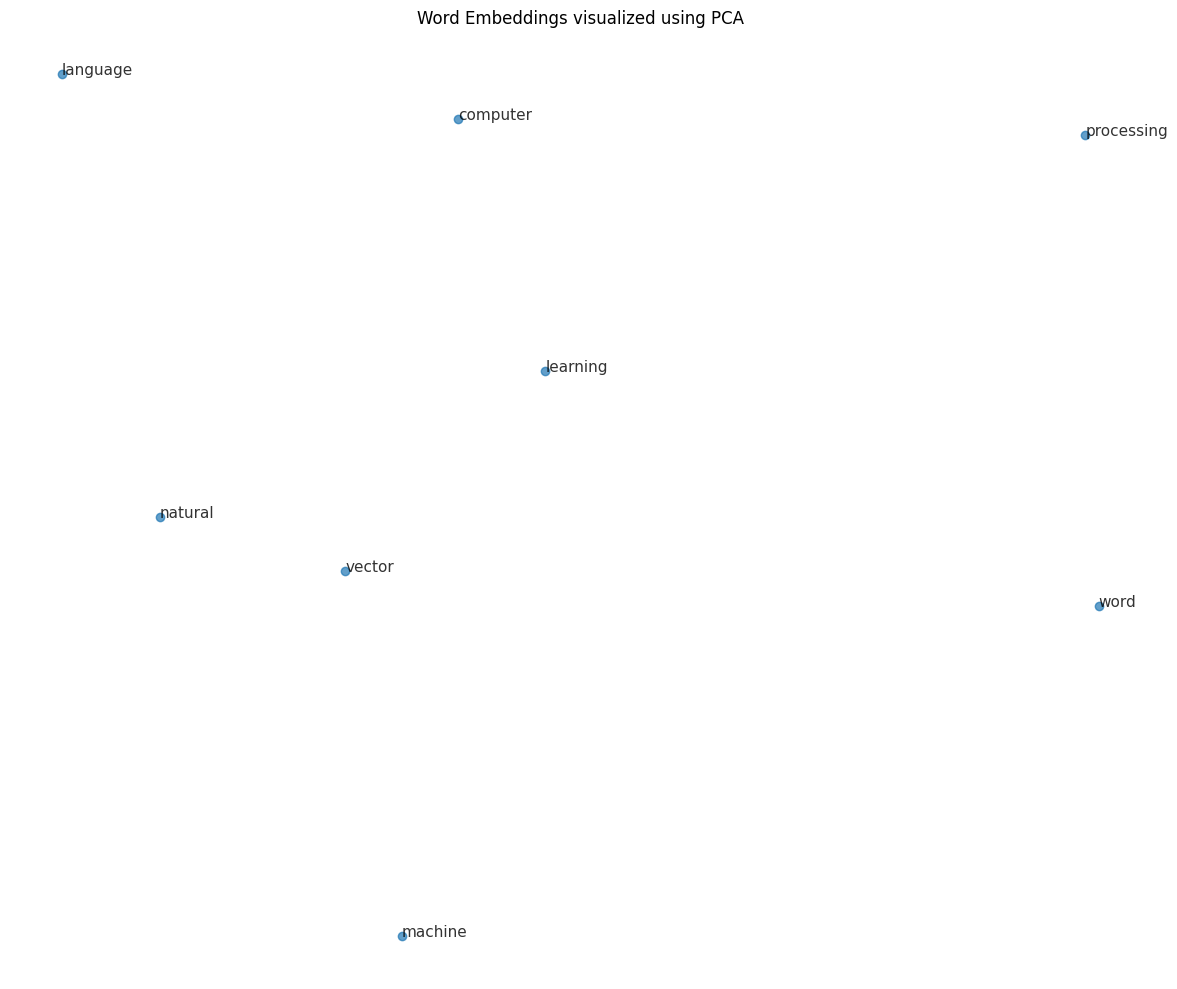


Evaluating model on word similarity task:
Spearman correlation: 0.8000 (p-value: 0.2000)
Evaluated on 4 word pairs

Evaluating model on word analogy task:
Analogy accuracy: 0.0000 (0/2)
Out-of-vocabulary analogies: 1


In [3]:
if __name__ == "__main__":
    # Sample text for demonstration
    sample_text = """
    Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence
    concerned with the interactions between computers and human language, in particular how to program computers
    to process and analyze large amounts of natural language data. The goal is a computer capable of understanding
    the contents of documents, including the contextual nuances of the language within them. The technology can then
    accurately extract information and insights contained in the documents as well as categorize and organize the
    documents themselves.

    Challenges in natural language processing frequently involve speech recognition, natural language understanding,
    and natural language generation. Modern NLP algorithms are based on machine learning, especially statistical
    machine learning and deep learning approaches. Deep learning models have achieved state-of-the-art results
    in many natural language tasks. These tasks include machine translation, text classification, discourse analysis,
    question answering and many more.

    Word embeddings are a type of word representation that allows words with similar meaning to have a similar
    representation. They are a distributed representation for text that is perhaps one of the key breakthroughs
    for the impressive performance of deep learning methods on challenging natural language processing problems.

    The skip-gram model is an efficient method for learning high-quality distributed vector representations that
    capture a large number of precise syntactic and semantic word relationships. It represents each word in a
    lower-dimensional vector space by considering the context in which the word appears.
    """

    # Create and train model
    model = SkipGram(sample_text, embedding_dim=50, window_size=2, min_count=2)
    model.train(epochs=10, batch_size=16, print_every=50)

    # Display similar words
    print("\nMost similar words to 'language':")
    similar_words = model.most_similar('language', n=5)
    for word, score in similar_words:
        print(f"{word}: {score:.4f}")

    # Try a word analogy
    print("\nWord analogy: language - natural + artificial = ?")
    analogy_results = model.analogy('language', 'natural', 'artificial', n=3)
    for word, score in analogy_results:
        print(f"{word}: {score:.4f}")

    # Visualize some word embeddings
    words_to_visualize = ['natural', 'language', 'processing', 'computer', 'artificial',
                         'intelligence', 'machine', 'learning', 'model', 'vector', 'word']
    model.visualize_embeddings(words_to_visualize, method='pca')

    # Sample evaluation datasets
    similarity_dataset = [
        ('natural', 'language', 0.8),
        ('machine', 'learning', 0.9),
        ('artificial', 'intelligence', 0.85),
        ('computer', 'machine', 0.7),
        ('language', 'word', 0.6)
    ]

    analogy_dataset = [
        ('natural', 'language', 'artificial', 'intelligence'),
        ('language', 'processing', 'machine', 'learning'),
        ('word', 'vector', 'deep', 'learning')
    ]

    # Evaluate model
    print("\nEvaluating model on word similarity task:")
    model.evaluate_similarity(similarity_dataset)

    print("\nEvaluating model on word analogy task:")
    model.evaluate_analogies(analogy_dataset)

# Source

- https://spotintelligence.com/2023/07/11/skip-gram-models-explained-how-to-create-embeddings-in-word2vec/